# <p style="background-color: khaki; font-family: Times New Roman; color: black; font-size: 120%; text-align: center; border-radius: 15px 15px; padding: 15px;"><strong>Prognozowanie przewlekłej choroby nerek</strong></p>
# <p style="font-family: Times New Roman; color: black; font-size: 80%; text-align: center; border-radius: 10px 10px; padding: 5px;"><strong>Krzysztof Kubina, Bartłomiej Węgrzyn, Krystian Węgrzyn, Paweł Węgrzyn</strong></p>

Projekt przedstawia zastosowanie oraz porównanie różnych modeli uczenia maszynowego. Dane dotyczą przewlekłej choroby nerek, które zawierają 25 cech i 400 wierszy. Ich celem jest przewidywanie czy dana osoba ma chorobę nerek.

## Wczytywanie danych i przegląd ogólny

Importujemy potrzebne biblioteki do analizy naszych danych.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA

# Pakiet do ignorowania ostrzeżeń
import warnings
warnings.filterwarnings('ignore')

nasz_seed = 23
nasz_seed_nienadzorowany = 32

Na początku wczytujemy zbiór danych dotyczący przewlekłej choroby nerek.

In [2]:
df = pd.read_csv('kidney_disease.csv', index_col = 'id')
df.head()

age    bp     sg   al   su     rbc        pc         pcc          ba  \
id                                                                          
0   48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1    7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

      bgr  ...  pcv    wc   rc  htn   dm cad appet   pe  ane classification  
id         ...                                                               
0   121.0  ...   44  7800  5.2  yes  yes  no  good   no   no            ckd  
1     NaN  ...   38  6000  NaN   no   no  no  good   no   no            ckd  
2   423.0  ...   31  7500  NaN   no  yes  no  poor   no  yes            ckd  
3   117.0  ...   32  6700  3.9  yes   no  no  poor  yes  yes            ckd  
4   106.0  ...   35  7300  4.6   no   no  no  good   no   no            ckd  

[5 rows x 25 columns]

Widzimy, że nazwy kolumn są nieintuicyjne, dlatego zmieniamy ich nazwy na bardziej zrozumiałe dla odbiorcy. Zmienione nazwy są w języku angielskim, ponieważ ich skróty są zapisane właśnie w tym języku.

In [3]:
col={'age': 'age',
     'bp': 'blood_pressure',
     'sg': 'specific_gravity',
     'al': 'albumin',
     'su': 'sugar',
     'rbc': 'red_blood_cells',
     'pc': 'pus_cell',
     'pcc': 'pus_cell_clumps',
     'ba': 'bacteria',
     'bgr': 'blood_glucose_random',
     'bu': 'blood_urea',
     'sc': 'serum_creatinine',
     'sod': 'sodium',
     'pot': 'potassium',
     'hemo': 'hemoglobin',
     'pcv': 'packed_cell_volume',
     'wc': 'white_blood_cell_count',
     'rc': 'red_blood_cell_count',
     'htn': 'hypertension',
     'dm': 'diabetes_mellitus',
     'cad': 'coronary_artery_disease',
     'appet': 'appetite',
     'pe': 'pedal_edema',
     'ane': 'anemia',
     'classification': 'class'}
df.rename(columns = col, inplace = True)
df.head()

age  blood_pressure  specific_gravity  albumin  sugar red_blood_cells  \
id                                                                           
0   48.0            80.0             1.020      1.0    0.0             NaN   
1    7.0            50.0             1.020      4.0    0.0             NaN   
2   62.0            80.0             1.010      2.0    3.0          normal   
3   48.0            70.0             1.005      4.0    0.0          normal   
4   51.0            80.0             1.010      2.0    0.0          normal   

    pus_cell pus_cell_clumps    bacteria  blood_glucose_random  ...  \
id                                                              ...   
0     normal      notpresent  notpresent                 121.0  ...   
1     normal      notpresent  notpresent                   NaN  ...   
2     normal      notpresent  notpresent                 423.0  ...   
3   abnormal         present  notpresent                 117.0  ...   
4     normal      notpresent  notpresent                 106.0  ...   

    packed_cell_volume  white_blood_cell_count  red_blood_cell_count  \
id                                                                     
0                   44                    7800                   5.2   
1                   38                    6000                   NaN   
2                   31                    7500                   NaN   
3                   32                    6700                   3.9   
4                   35                    7300                   4.6   

    hypertension  diabetes_mellitus coronary_artery_disease appetite  \
id                                                                     
0            yes                yes                      no     good   
1             no                 no                      no     good   
2             no                yes                      no     poor   
3            yes                 no                      no     poor   
4             no                 no                      no     good   

   pedal_edema anemia class  
id                           
0           no     no   ckd  
1           no     no   ckd  
2           no    yes   ckd  
3          yes    yes   ckd  
4           no     no   ckd  

[5 rows x 25 columns]

Zobaczmy wszystkie informacje o naszych zmiennych (liczba wypełnionych danych w każdej kolumni oraz ich typ).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      391 non-null    float64
 1   blood_pressure           388 non-null    float64
 2   specific_gravity         353 non-null    float64
 3   albumin                  354 non-null    float64
 4   sugar                    351 non-null    float64
 5   red_blood_cells          248 non-null    object 
 6   pus_cell                 335 non-null    object 
 7   pus_cell_clumps          396 non-null    object 
 8   bacteria                 396 non-null    object 
 9   blood_glucose_random     356 non-null    float64
 10  blood_urea               381 non-null    float64
 11  serum_creatinine         383 non-null    float64
 12  sodium                   313 non-null    float64
 13  potassium                312 non-null    float64
 14  hemoglobin               348 no

Widzimy, że w niektórych kolumnach występuje sporo wartości NA oraz mamy dwa typy danych `object` i `float64`.

Zobaczmy teraz na poszczególne wartości statystyczne naszych kolumn.

In [5]:
df.describe()

age  blood_pressure  specific_gravity     albumin       sugar  \
count  391.000000      388.000000        353.000000  354.000000  351.000000   
mean    51.483376       76.469072          1.017408    1.016949    0.450142   
std     17.169714       13.683637          0.005717    1.352679    1.099191   
min      2.000000       50.000000          1.005000    0.000000    0.000000   
25%     42.000000       70.000000          1.010000    0.000000    0.000000   
50%     55.000000       80.000000          1.020000    0.000000    0.000000   
75%     64.500000       80.000000          1.020000    2.000000    0.000000   
max     90.000000      180.000000          1.025000    5.000000    5.000000   

       blood_glucose_random  blood_urea  serum_creatinine      sodium  \
count            356.000000  381.000000        383.000000  313.000000   
mean             148.036517   57.425722          3.072454  137.528754   
std               79.281714   50.503006          5.741126   10.408752   
min               22.000000    1.500000          0.400000    4.500000   
25%               99.000000   27.000000          0.900000  135.000000   
50%              121.000000   42.000000          1.300000  138.000000   
75%              163.000000   66.000000          2.800000  142.000000   
max              490.000000  391.000000         76.000000  163.000000   

        potassium  hemoglobin  
count  312.000000  348.000000  
mean     4.627244   12.526437  
std      3.193904    2.912587  
min      2.500000    3.100000  
25%      3.800000   10.300000  
50%      4.400000   12.650000  
75%      4.900000   15.000000  
max     47.000000   17.800000

Statystyki przedstawiają dane dotyczące 400 pacjentów, w tym średni wiek 51.48 lat, średnie ciśnienie krwi 76.47 mmHg i średni poziom hemoglobiny 12.53 g/dL. Wartości dla pozostałych parametrów, takich jak ciężar właściwy moczu, albumina, cukier, glukoza, mocznik, kreatynina, sód i potas, pokazują szeroki zakres wyników od normalnych do skrajnych, co wskazuje na różnorodność stanu zdrowia badanej populacji.

Sprawdźmy teraz ile jest wartości NA w naszym zbiorze danych w poszczególnych kolumnach.

In [6]:
df.isna().sum().sort_values(ascending=False)

red_blood_cells            152
red_blood_cell_count       130
white_blood_cell_count     105
potassium                   88
sodium                      87
packed_cell_volume          70
pus_cell                    65
hemoglobin                  52
sugar                       49
specific_gravity            47
albumin                     46
blood_glucose_random        44
blood_urea                  19
serum_creatinine            17
blood_pressure              12
age                          9
bacteria                     4
pus_cell_clumps              4
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
pedal_edema                  1
anemia                       1
class                        0
dtype: int64

Widzimy, że najwięcej wartości NA występuje w kolumnie `red_blood_cells` oraz `red_blood_cell_count`. Zajmiemy się nimi później.

Kolumny `packed_cell_volume`, `white_blood_cell_count` i `red_blood_cell_count` są typu obiektowego. Zatem przekonwerujemy je na typ numeryczny. Wybieramy je ponieważ w rzeczywistości powinny być one liczbowe.

In [7]:
df['packed_cell_volume'] = pd.to_numeric(df['packed_cell_volume'], errors = 'coerce')
df['white_blood_cell_count'] = pd.to_numeric(df['white_blood_cell_count'], errors = 'coerce')
df['red_blood_cell_count'] = pd.to_numeric(df['red_blood_cell_count'], errors = 'coerce')

Tworzymy dwie listy zawierające nazwy kolumn typu `object` (wartości kategoryczne) i te, które nie są tym typem (wartości numeryczne).

In [8]:
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = [col for col in df.columns if df[col].dtype != 'object']

Nastepnie wyświetlmy je.

In [9]:
cat_cols

['red_blood_cells',
 'pus_cell',
 'pus_cell_clumps',
 'bacteria',
 'hypertension',
 'diabetes_mellitus',
 'coronary_artery_disease',
 'appetite',
 'pedal_edema',
 'anemia',
 'class']

In [10]:
num_cols

['age',
 'blood_pressure',
 'specific_gravity',
 'albumin',
 'sugar',
 'blood_glucose_random',
 'blood_urea',
 'serum_creatinine',
 'sodium',
 'potassium',
 'hemoglobin',
 'packed_cell_volume',
 'white_blood_cell_count',
 'red_blood_cell_count']

Wyświetlmy zatem unikalne wartości, które są w kolumnach kategorycznych.

In [11]:
for col in cat_cols:
    print(f'{col} has {df[col].unique()} values\n')

red_blood_cells has [nan 'normal' 'abnormal'] values

pus_cell has ['normal' 'abnormal' nan] values

pus_cell_clumps has ['notpresent' 'present' nan] values

bacteria has ['notpresent' 'present' nan] values

hypertension has ['yes' 'no' nan] values

diabetes_mellitus has ['yes' 'no' ' yes' '\tno' '\tyes' nan] values

coronary_artery_disease has ['no' 'yes' '\tno' nan] values

appetite has ['good' 'poor' nan] values

pedal_edema has ['no' 'yes' nan] values

anemia has ['no' 'yes' nan] values

class has ['ckd' 'ckd\t' 'notckd'] values



Możemy zauważyć, że większość kolumn ma 2 kategorie, jednak przez błędne wpisywanie ta jedna kategoria jest wpisywana podwójnie (np. *'yes'* i *' yes'* w kolumnie `diabetes_mellitus`).

Zatem poprawiamy wszystkie błędy (źle wprowadzone nazwy kategorii) w kolumnach kategorycznych.

In [12]:
df['diabetes_mellitus'].replace(to_replace = {'\tno': 'no',
                                            '\tyes': 'yes',
                                            ' yes': 'yes'},
                                            inplace = True)

df['coronary_artery_disease'].replace(to_replace = {'\tno': 'no'},
                                                  inplace = True)

df['class'].replace(to_replace = {'ckd\t': 'ckd',
                                'notckd': 'not ckd'},
                                inplace = True)

Wykonujemy one-hot-coding (zmieniamy wartości jakościowe na ilościowe, binarne) na kolumnie `class`.

In [13]:
df['class'] = df['class'].map({'ckd': 0, 'not ckd': 1})
df['class'] = pd.to_numeric(df['class'], errors = 'coerce')

## Wizualizacja naszych danych

Zobaczmy jak wygląda rozkład wartości numerycznych na histogramach.

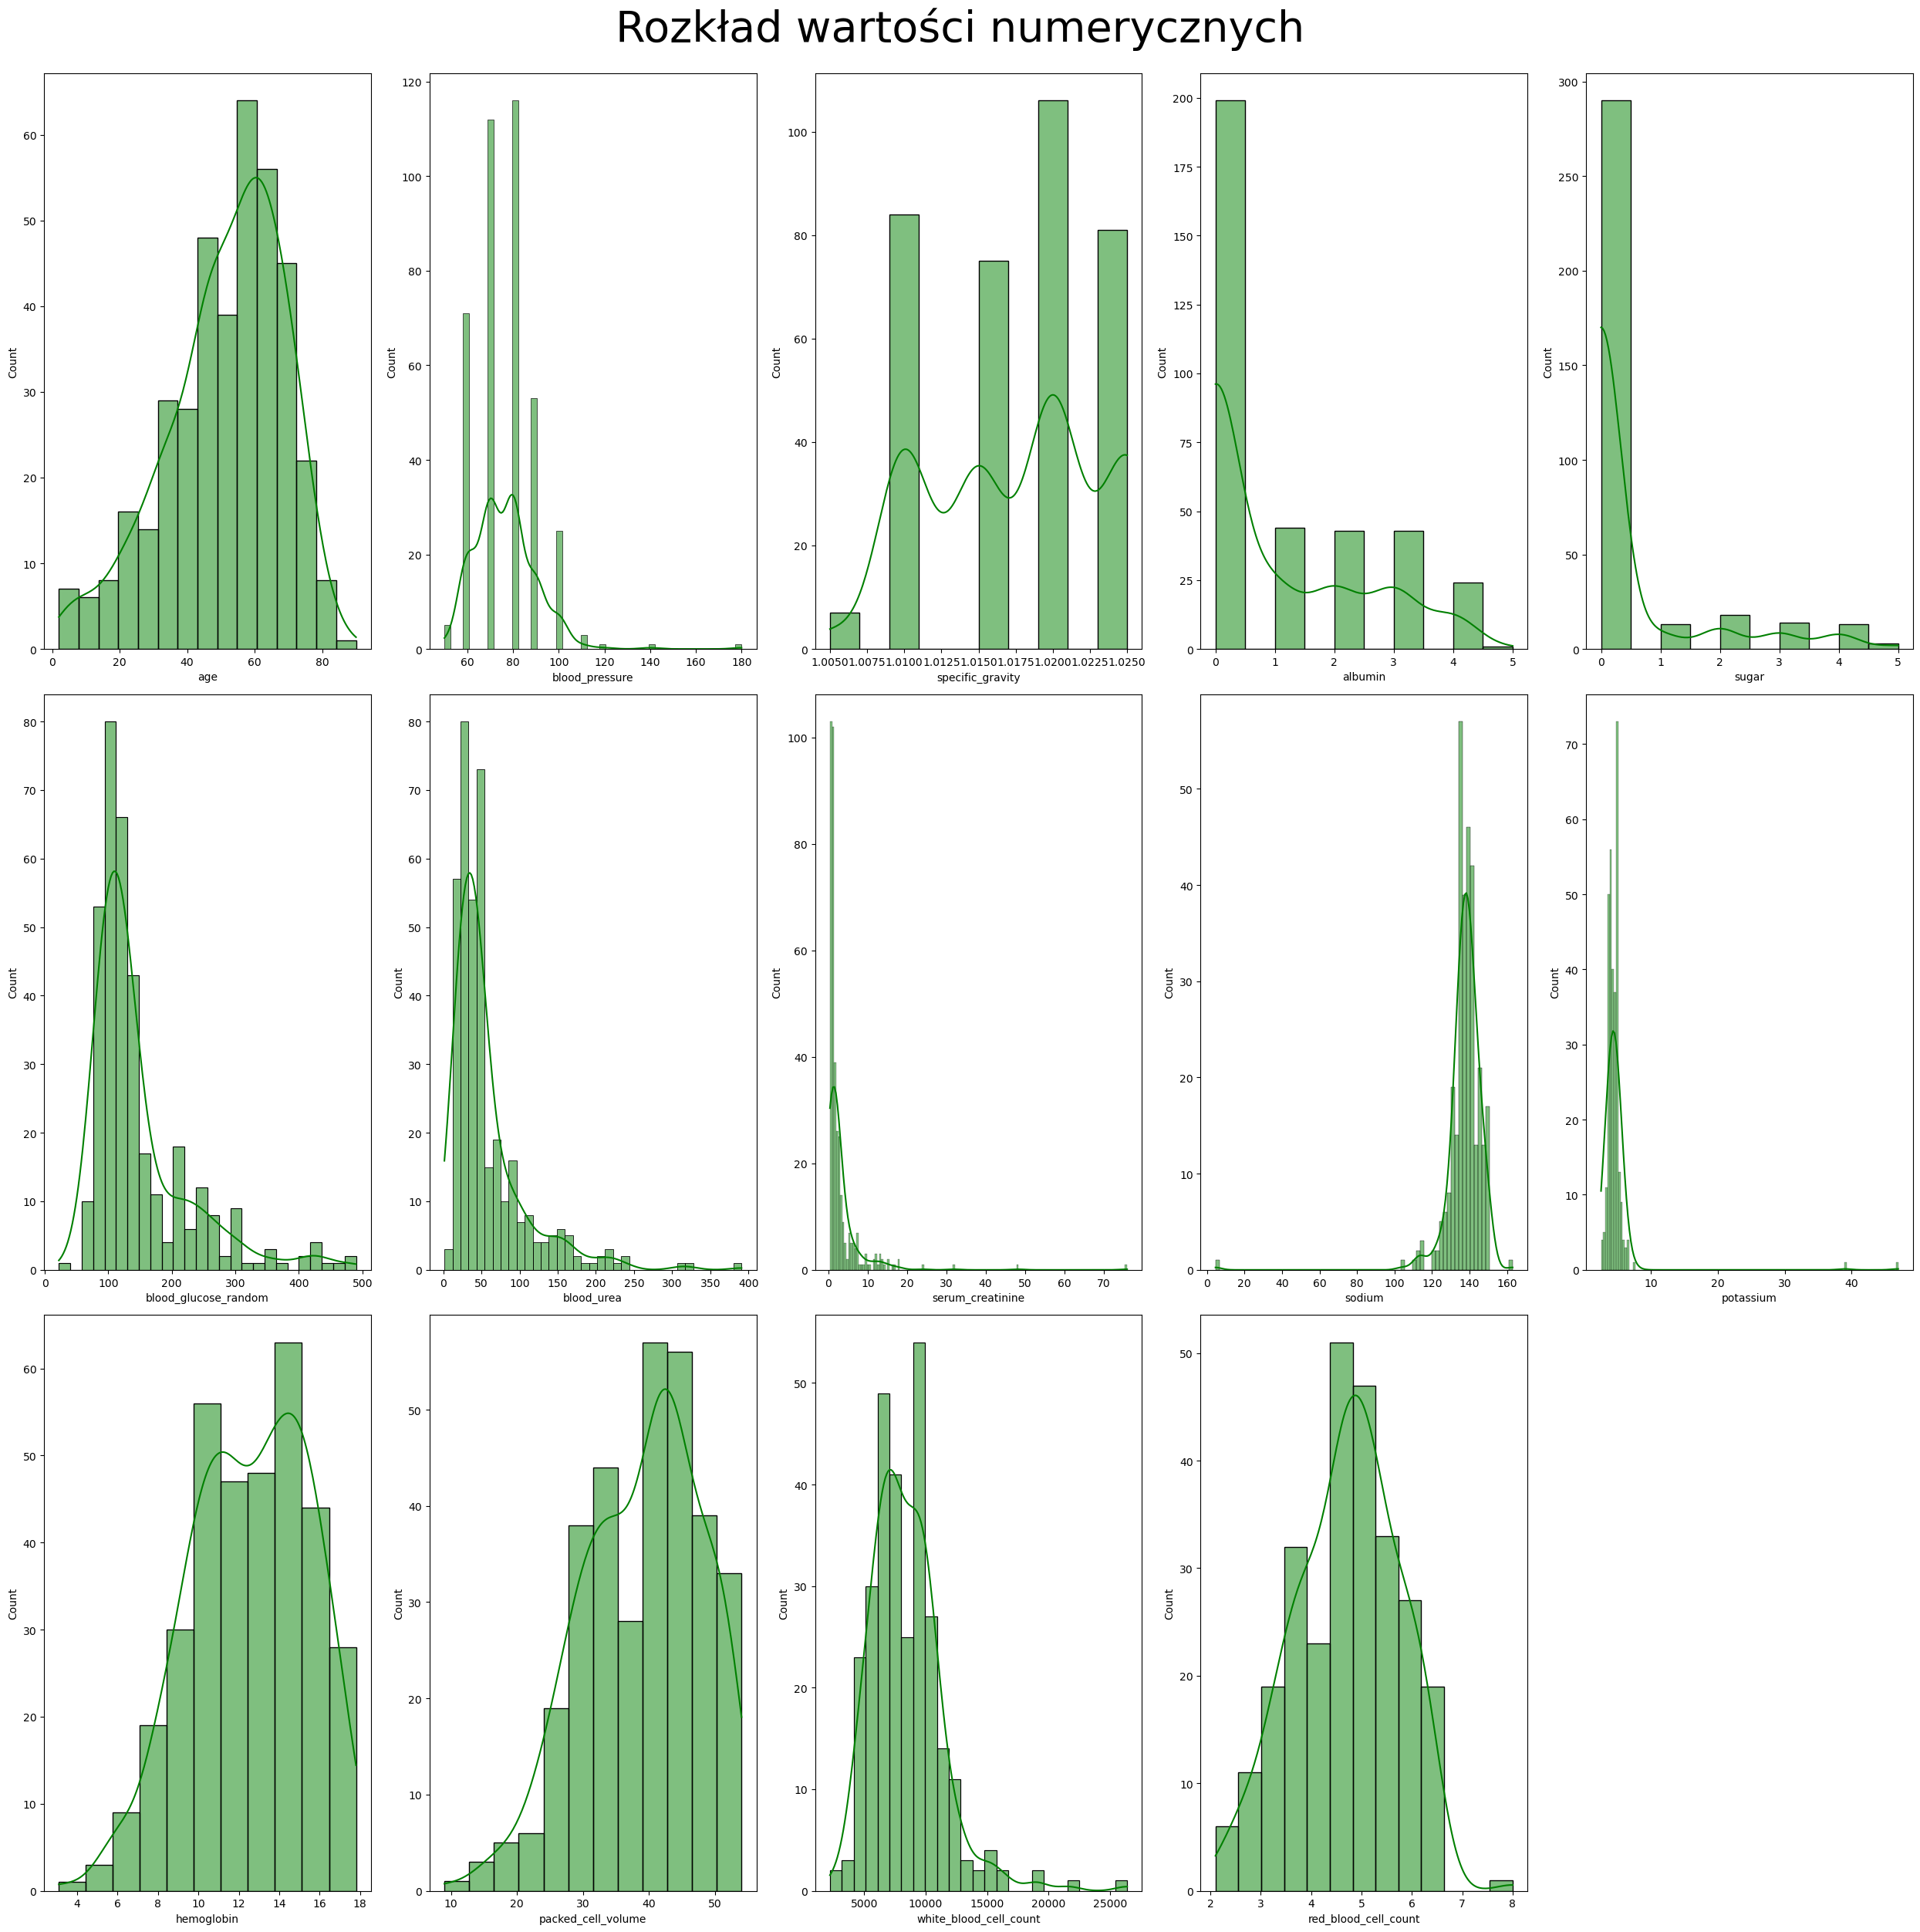

In [14]:
plt.figure(figsize=(25, 25))
plotnumber = 1

for column in num_cols:
    if plotnumber <= 14:
        ax = plt.subplot(3, 5, plotnumber)
        sns.histplot(df[column], kde=True, color='green')
        plt.xlabel(column)
        
    plotnumber += 1

plt.suptitle('Rozkład wartości numerycznych', fontsize=40, y=1)
plt.tight_layout()
plt.show()

1. **Wiek (age)**: Większość pacjentów mieści się w wieku 40-70 lat, co może sugerować, że schorzenia związane z badanymi parametrami częściej występują w tej grupie wiekowej.
2. **Ciśnienie krwi (blood_pressure)**: Przypadki bardzo wysokiego ciśnienia krwi mogą wskazywać na niewłaściwe leczenie lub inne czynniki, takie jak styl życia.
3. **Albumina (albumin)**: Niski poziom albuminy u większości pacjentów może sugerować problemy z nerkami lub niedożywienie.
4. **Cukier (sugar)**: Dominująca liczba pacjentów bez cukru w moczu, przy jednoczesnym istnieniu znacznej liczby z podwyższonym poziomem cukru, może sugerować niewykrytą cukrzycę.
5. **Glukoza we krwi (blood_glucose_random)**: Znaczące odchylenia w poziomie losowej glukozy we krwi mogą wskazywać na niewłaściwie kontrolowaną cukrzycę.
6. **Mocznik we krwi (blood_urea)**: Skrajne wartości mocznika mogą sugerować poważne problemy z nerkami, będące efektem przewlekłych chorób lub nagłych problemów zdrowotnych.
7. **Kreatynina w surowicy (serum_creatinine)**: Skrajne wartości kreatyniny mogą być oznaką poważnych problemów z nerkami.
8. **Sód (sodium)**: Odchylenia w wartościach sodu mogą być związane z dietą, stanem zdrowia lub stosowanymi lekami.
9. **Potas (potassium)**: Odchylenia w wartościach potasu mogą również być związane z dietą, stanem zdrowia lub lekami.
10. **Hemoglobina (hemoglobin)**: Różne poziomy hemoglobiny, z niektórymi pacjentami mającymi wartości poniżej normy, mogą oznaczać znaczącą liczbę pacjentów z anemią spowodowaną niedoborami żywieniowymi, przewlekłymi chorobami czy innymi czynnikami.

Popatrzmy teraz na liczność grup w kolumnach kategorycznych.

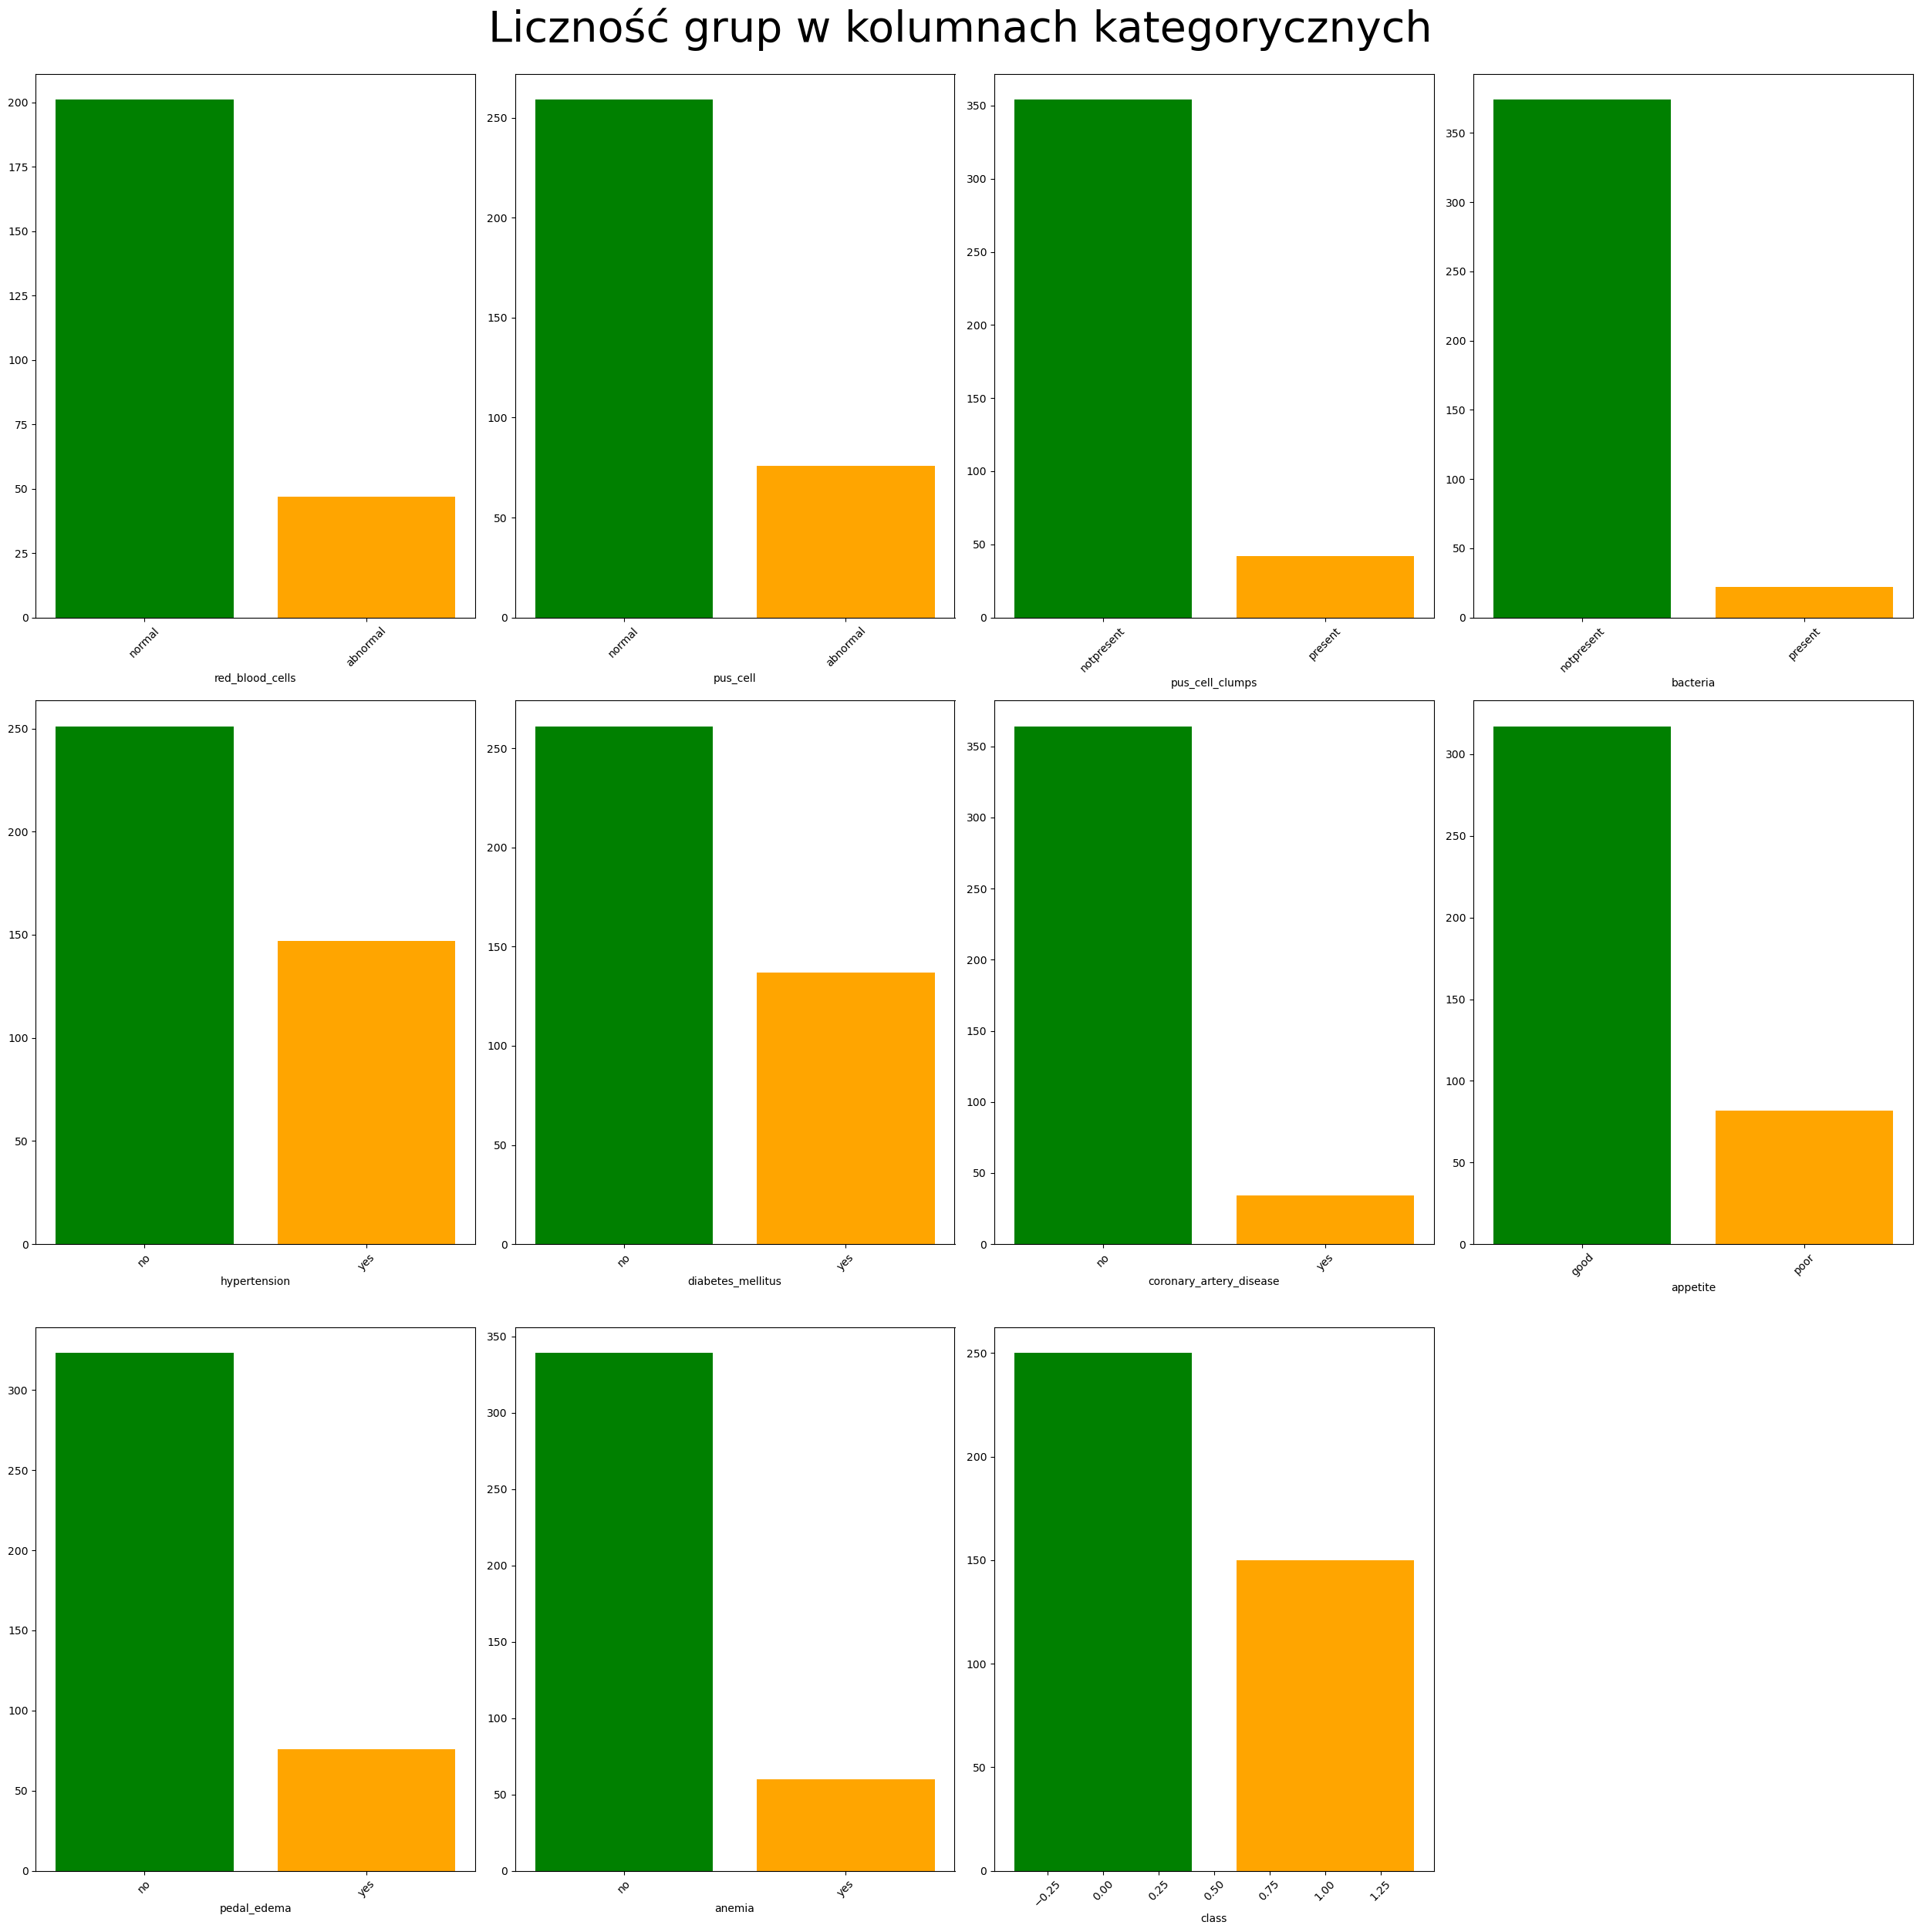

In [15]:
plt.figure(figsize = (25, 25))
plotnumber = 1

colors = ['green', 'orange', 'pink', 'salmon', 'lightcoral', 'cyan', 'blue']

for column in cat_cols:
    if plotnumber <= 11:
        ax = plt.subplot(3, 4, plotnumber)
        counts = df[column].value_counts()
        ax.bar(counts.index, counts.values, color=colors[:len(counts)])
        plt.xlabel(column)
        plt.xticks(rotation = 45)
        plt.xlabel(column)
        
    plotnumber += 1

plt.suptitle('Liczność grup w kolumnach kategorycznych', fontsize = 40, y = 1)
plt.tight_layout()
plt.show()

Widzimy, że w żadnej kolumnie wartości nie są równoliczne, a w niektórych widzimy wręcz skrajną różnicę.

1. **Płeć (sex)**: Większość pacjentów to mężczyźni, co może sugerować wyższą zachorowalność lub większą skłonność do diagnozowania w tej grupie.
2. **Krwinki białe (rbc)**: Przewaga pacjentów z prawidłowym poziomem czerwonych krwinek może wskazywać na mniej powszechne problemy z anemią.
3. **Odleżyny (pus_cell)**: Znacząca liczba pacjentów z odleżynami może wskazywać na problemy z długotrwałą opieką medyczną.
4. **Odleżyny (pus_cell_clumps)**: Większość pacjentów nie ma odleżyn w grupach, co sugeruje, że odleżyny występują raczej pojedynczo.
5. **Bakterie (bacteria)**: Większość pacjentów nie ma bakterii w badaniach, co wskazuje na mniejszą częstość zakażeń bakteryjnych.
6. **Nadciśnienie (hypertension)**: Większość pacjentów ma nadciśnienie, co może być poważnym czynnikiem ryzyka dla innych chorób.
7. **Cukrzyca (diabetes_mellitus)**: Znacząca liczba pacjentów ma cukrzycę, co wskazuje na jej powszechność w badanej grupie.
8. **Choroby układu moczowego (coronary_artery_disease)**: Większość pacjentów nie ma chorób układu moczowego, co jest pozytywnym wskaźnikiem zdrowia nerek.
9. **Niedokrwistość (appetite)**: Znacząca liczba pacjentów nie ma niedokrwistości, co może wskazywać na stosunkowo dobrą jakość diety i stan odżywienia w grupie badanej.

Stwórzmy macierz korelacji dla kolumn o wartościach numerycznych.

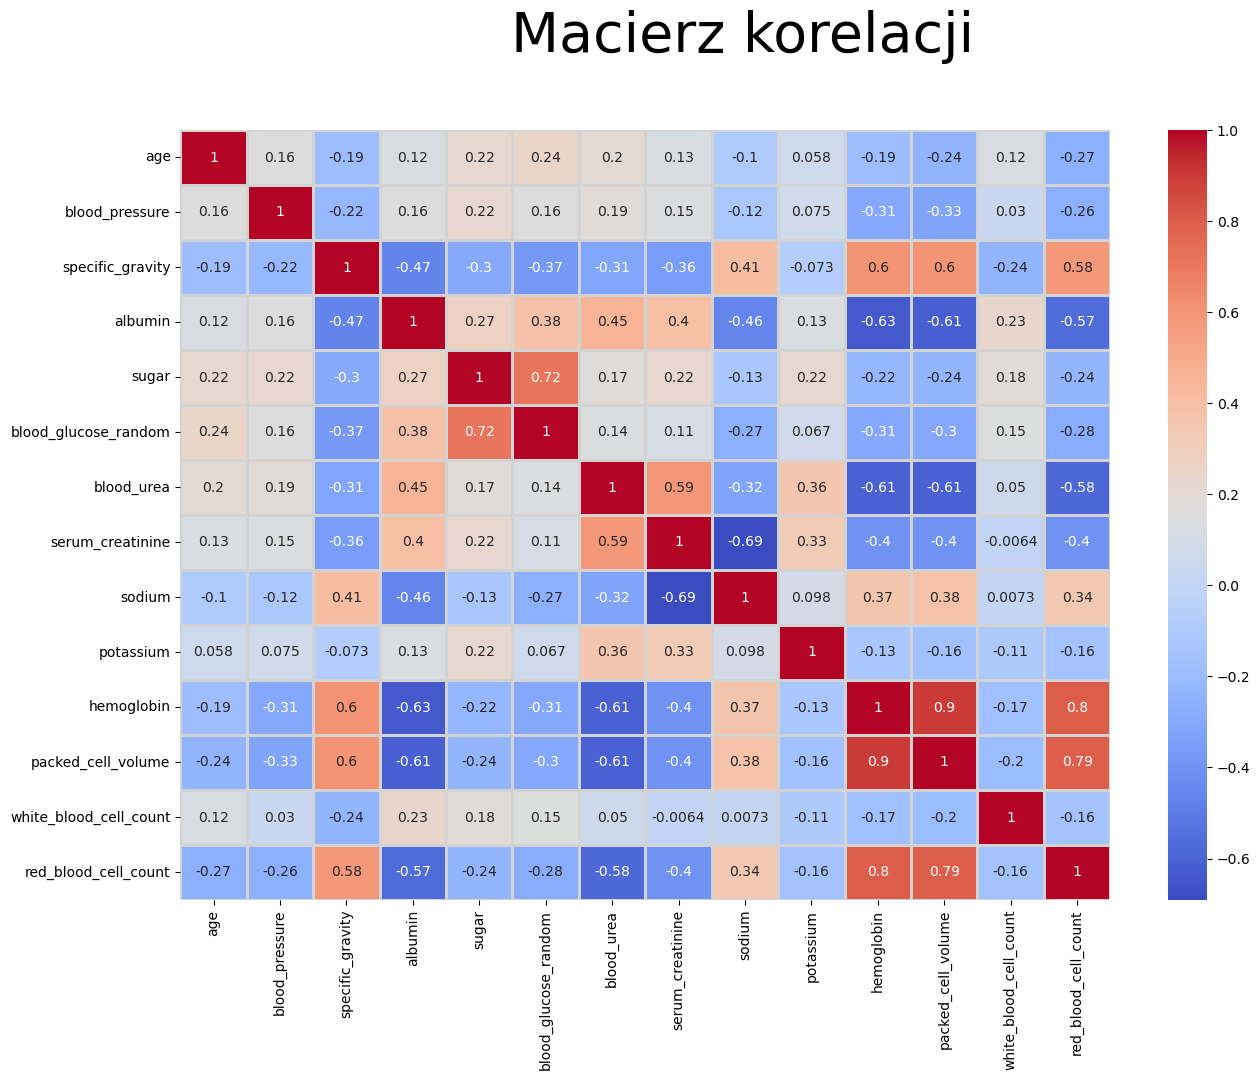

In [16]:
num_df = df[num_cols]

plt.figure(figsize = (15, 10))
sns.heatmap(num_df.corr(), annot = True, cmap = 'coolwarm', linewidths = 2, linecolor = 'lightgrey')
plt.suptitle('Macierz korelacji', fontsize = 40, y = 1)
plt.show()

#### Największe korelacje:
- **Packed_cell_volume i hemoglobin (0.9)**: Wysoka dodatnia korelacja wskazuje, że większa objętość krwinek paczkowanych jest ściśle związana z wyższym poziomem hemoglobiny, co jest zgodne z oczekiwaniami, ponieważ hemoglobina jest głównym składnikiem czerwonych krwinek.
- **Hemoglobin i red_blood_cell_count (0.8)**: Silna dodatnia korelacja sugeruje, że wyższy poziom hemoglobiny jest związany z większą liczbą czerwonych krwinek, co również jest logiczne, ponieważ hemoglobina jest zawarta w czerwonych krwinkach.

#### Najmniejsze korelacje:
- **Serum_creatinine i white_blood_cell_count (-0.0064)**: Bardzo niska korelacja wskazuje, że poziom kreatyniny w surowicy nie ma praktycznie żadnego związku z liczbą białych krwinek.
- **Blood_glucose_random i packed_cell_volume (0.067)**: Bardzo niska korelacja sugeruje, że losowy poziom glukozy we krwi ma minimalny wpływ na objętość krwinek paczkowanych.


## Uzupełnianie brakujących danych

Powróćmy do wartości NA w naszych kolumnach. Wyświetlmy je jeszcze raz i posortujmy malejąco.

In [17]:
df.isna().sum().sort_values(ascending=False)

red_blood_cells            152
red_blood_cell_count       131
white_blood_cell_count     106
potassium                   88
sodium                      87
packed_cell_volume          71
pus_cell                    65
hemoglobin                  52
sugar                       49
specific_gravity            47
albumin                     46
blood_glucose_random        44
blood_urea                  19
serum_creatinine            17
blood_pressure              12
age                          9
bacteria                     4
pus_cell_clumps              4
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
pedal_edema                  1
anemia                       1
class                        0
dtype: int64

Zwizualizujmy brakujące wartości na wykresie.

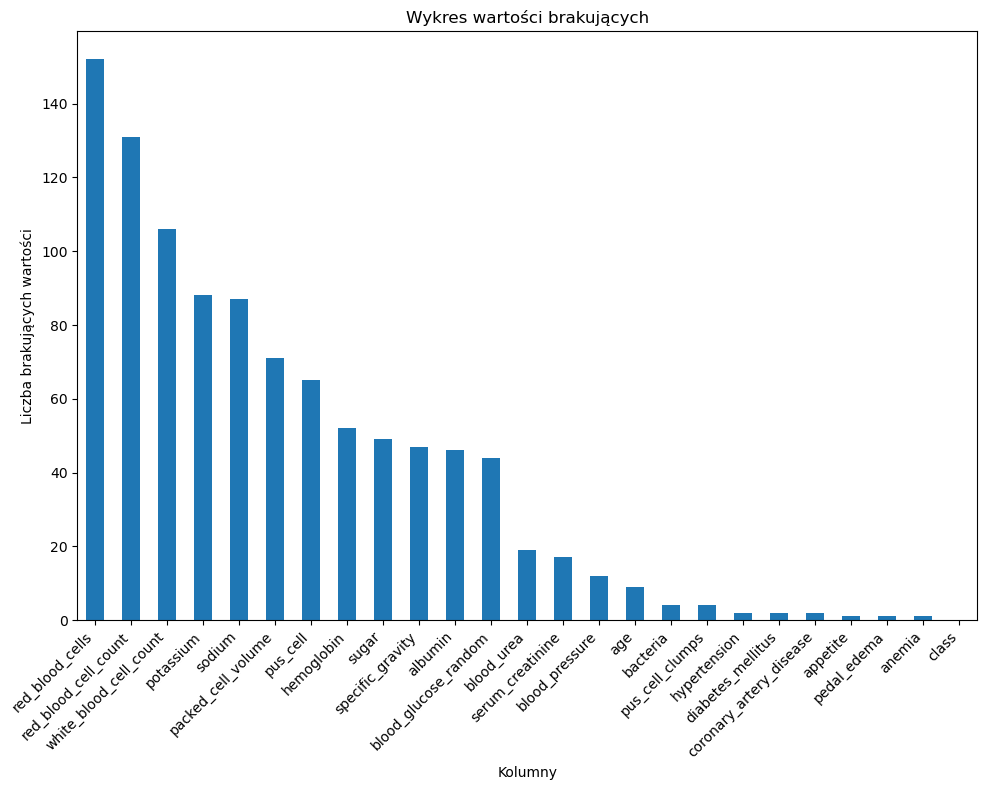

In [18]:
missing_values = (df.isna().sum()).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
missing_values.plot(kind='bar')
plt.title('Wykres wartości brakujących')
plt.xlabel('Kolumny')
plt.ylabel('Liczba brakujących wartości')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Na początku uzupełnijmy kolumny o wartościach numerycznych. Użyjemy do tego funkcji `IterativeImputer` z biblioteki sklearn. Wartości NA będą uzupełnione średnią.

In [19]:
imputer = IterativeImputer(random_state=nasz_seed, initial_strategy = 'mean', max_iter=10, sample_posterior=True)

df[num_cols] = imputer.fit_transform(df[num_cols])

Sprawdźmy czy funkcja poprawnie zamieniła wartości NA na średnią.

In [20]:
df[num_cols].isnull().sum()

age                       0
blood_pressure            0
specific_gravity          0
albumin                   0
sugar                     0
blood_glucose_random      0
blood_urea                0
serum_creatinine          0
sodium                    0
potassium                 0
hemoglobin                0
packed_cell_volume        0
white_blood_cell_count    0
red_blood_cell_count      0
dtype: int64

Dla zmiennych kategorycznych, które posiadają dużo wartości NA wstawmy losowe wartości, natomiast dla kolumn, które posiadają kilka wartości NA wstawiamy modę.

In [21]:
def random_value_imputation(feature):
    random_sample = df[feature].dropna().sample(df[feature].isna().sum())
    random_sample.index = df[df[feature].isnull()].index
    df.loc[df[feature].isnull(), feature] = random_sample

def impute_mode(feature):
    mode = df[feature].mode()[0]
    df[feature] = df[feature].fillna(mode)
    
# W przypadku kolumn kategorycznych red_blood_cells i pus_cell do wypełnienia używamy funkcji random_value_imputation
random_value_imputation('red_blood_cells')
random_value_imputation('pus_cell')

# W przypadku innych kolumn używamy funkcji impute_mode
for col in cat_cols:
    impute_mode(col)

Upewnijmy się, czy nasze funkcje zadziałały poprawnie.

In [22]:
df[cat_cols].isnull().sum()

red_blood_cells            0
pus_cell                   0
pus_cell_clumps            0
bacteria                   0
hypertension               0
diabetes_mellitus          0
coronary_artery_disease    0
appetite                   0
pedal_edema                0
anemia                     0
class                      0
dtype: int64

Widzimy, że nasze funkcje poprawnie zamieniły wartości NA w tych kolumnach.

W następnej kolejności sprawdzamy wskaźnik VIF (Variance Inflation Factor) w kolumnach numerycznych. Aby go obliczyć dodajmy kolumnę stałej równej 1 (co jest konieczne, aby zapewnić poprawne działanie obliczeń wskaźnika VIF), a następnie posortujmy wyniki według wartości VIF w kolejności malejącej.

In [23]:
# Dodajmy kolumnę stałej
df_vif = df.copy()
df_vif['const'] = 1

# Wybierzmy kolumny, dla których ma być obliczony VIF
X = df_vif[num_cols + ['const']]

# Obliczmy VIF
vif_info = pd.DataFrame()
vif_info['Column'] = X.columns
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info = vif_info.sort_values('VIF', ascending=False)

# Wyświetlmy wyniki
vif_info

Column           VIF
14                   const  44598.577222
10              hemoglobin      4.794401
11      packed_cell_volume      4.773441
7         serum_creatinine      2.936475
13    red_blood_cell_count      2.462956
6               blood_urea      2.443470
8                   sodium      2.272569
5     blood_glucose_random      2.064098
4                    sugar      2.011849
3                  albumin      1.800179
2         specific_gravity      1.558402
9                potassium      1.206411
1           blood_pressure      1.173482
0                      age      1.129847
12  white_blood_cell_count      1.092360

Zobaczmy jak wskaźnik VIF prezentuje się na wykresie. Na początku usuńmy kolumnę `const`, która jest niepotrzebna, ponieważ była dodana tylko w celu utworzenia kolumny ze wskaźnikiem VIF.

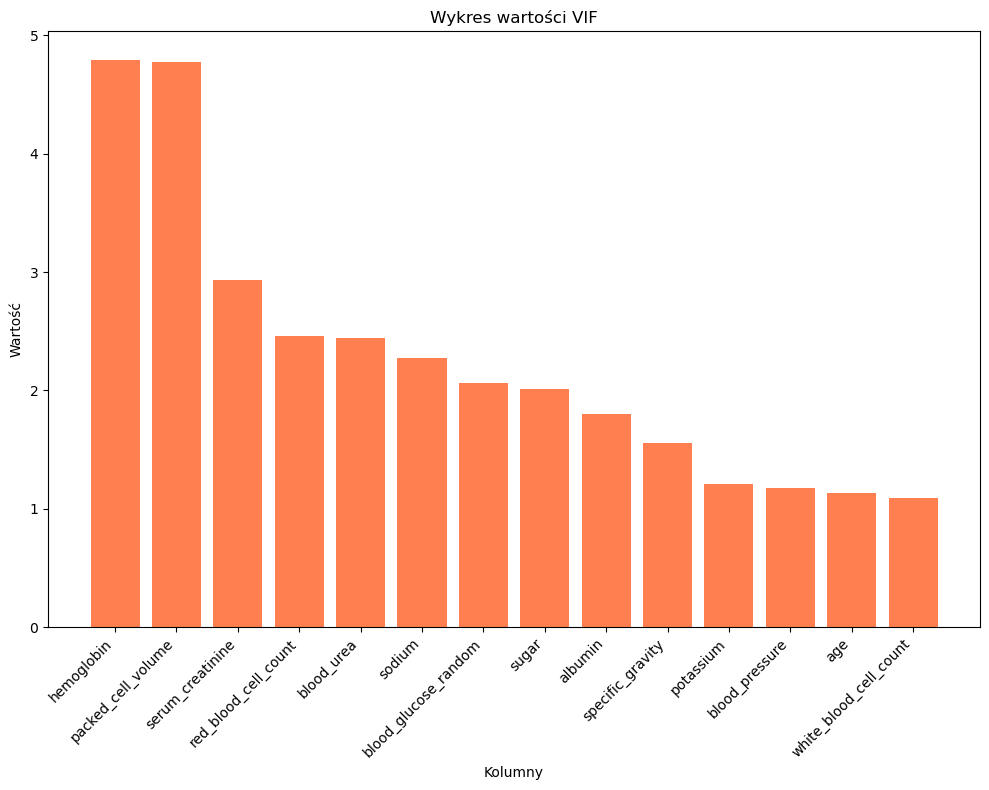

In [24]:

vif_info_filtered = vif_info[vif_info['Column'] != 'const']
vif_info_sorted = vif_info_filtered.sort_values('VIF', ascending=False)

plt.figure(figsize=(10, 8))
plt.bar(vif_info_sorted['Column'], vif_info_sorted['VIF'], color='coral')
plt.xlabel('Kolumny')
plt.ylabel('Wartość')
plt.title('Wykres wartości VIF')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

VIF wskazuje na obecność pewnej współliniowości w danych, zwłaszcza w przypadku kilku zmiennych. Wysokie wartości VIF dla `Hemoglobin` i `Packed Cell Volume` sugerują silną współliniowość tych zmiennych z innymi cechami, co może negatywnie wpływać na modele regresji. Zmienne takie jak `Serum Creatinine`, `Red Blood Cell Count`, `Blood Urea` i kilka innych mają umiarkowane wartości VIF, co również może wskazywać na współliniowość. Pozostałe zmienne mają niskie wartości VIF, co sugeruje minimalną współliniowość i mniejsze ryzyko problemów w analizach.

## Konwersja zmiennych

Następnie konwertujemy zmienne kategoryczne (object) na numeryczne (int32) używając `LabelEncoder`.

In [25]:
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      400 non-null    float64
 1   blood_pressure           400 non-null    float64
 2   specific_gravity         400 non-null    float64
 3   albumin                  400 non-null    float64
 4   sugar                    400 non-null    float64
 5   red_blood_cells          400 non-null    int32  
 6   pus_cell                 400 non-null    int32  
 7   pus_cell_clumps          400 non-null    int32  
 8   bacteria                 400 non-null    int32  
 9   blood_glucose_random     400 non-null    float64
 10  blood_urea               400 non-null    float64
 11  serum_creatinine         400 non-null    float64
 12  sodium                   400 non-null    float64
 13  potassium                400 non-null    float64
 14  hemoglobin               400 no

Widzimy, że poprawnie zamieniliśmy typ danych, zatem możemy przejść do budowania modeli z naszych danych.

## Przygotowanie danych do modelowania

Zacznijmy od wyrzucenia naszej zmiennej niezależnej `class` oraz utwórzmy nasze zbiory treningowe X i y.

In [27]:
ind_col = [col for col in df.columns if col != 'class']

# Zdefiniujmy nazwę zmiennej zależnej
dep_col = 'class'

X = df[ind_col]
y = df[dep_col]

Po określeniu, która zmienna jest niezależna, dzielimy zbiór na treningowy i testowy w proporcji 3:1.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.75, random_state = nasz_seed)

Przeprowadźmy normalizację naszych danych.

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Po przygotowaniu danych, przechodzimy do budowania naszych modeli.


## Uczenie nadzorowane

### K-najbliższych sąsiadów

Pierwszy model zbudujemy na podstawie algorytmu k-najbliższych sąsiadów.

Polega on na przyporządkowaniu nowego punktu danych do klasy na podstawie większości klasyfikacji jego najbliższych sąsiadów z zestawu treningowego. Kluczowym parametrem jest liczba sąsiadów (k), którą trzeba ustalić przed zastosowaniem algorytmu. Algorytm jest prosty, ale może być wolny w działaniu dla dużych zbiorów danych.

In [30]:
# Stwórzmy klasyfikator KNN
knn = KNeighborsClassifier()

# Wytrenujmy go
knn.fit(X_train, y_train)

# Utwórzmy predykcję na zbiorze testowym
y_pred = knn.predict(X_test)

print(f'Dokładność na zbiorze treningowym wynosi: {accuracy_score(y_train, knn.predict(X_train))}\n')

# Obliczmy główne metryki klasyfikacji
knn_accuracy = accuracy_score(y_test, y_pred)
knn_precision = precision_score(y_test, y_pred, average='macro')
knn_recall = recall_score(y_test, y_pred, average='macro')
knn_f1_score = f1_score(y_test, y_pred, average='macro')

# Wyświetlmy macierz pomyłek oraz metryki klasyfikacji
print(f"Macierz pomyłek: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Dokładność na zbiorze testowym: {knn_accuracy} \n")
print(f"Precyzja na zbiorze testowym: {knn_precision} \n")
print(f"Wskaźnik Recall na zbiorze testowym: {knn_recall} \n")
print(f"F1_score na zbiorze testowym: {knn_f1_score} \n")
print(f"Raport klasyfikacji: \n {classification_report(y_test, y_pred)}")

Dokładność na zbiorze treningowym wynosi: 0.9

Macierz pomyłek: 
[[154  35]
 [  0 111]]

Dokładność na zbiorze testowym: 0.8833333333333333 

Precyzja na zbiorze testowym: 0.8801369863013699 

Wskaźnik Recall na zbiorze testowym: 0.9074074074074074 

F1_score na zbiorze testowym: 0.880886206622727 

Raport klasyfikacji: 
               precision    recall  f1-score   support

           0       1.00      0.81      0.90       189
           1       0.76      1.00      0.86       111

    accuracy                           0.88       300
   macro avg       0.88      0.91      0.88       300
weighted avg       0.91      0.88      0.89       300



### Regresja logistyczna

Następnym modelem, który zaprezentujemy jest model regresji logistycznej.

Regresja logistyczna jest algorytmem uczenia maszynowego używanym głównie do klasyfikacji binarnej. Modeluje prawdopodobieństwo przynależności do jednej z dwóch klas, wykorzystując funkcję logistyczną

In [31]:
logreg = LogisticRegression(random_state = nasz_seed)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Dokładność na zbiorze treningowym wynosi: {accuracy_score(y_train, logreg.predict(X_train))}\n')

logreg_accuracy = accuracy_score(y_test, y_pred)
logreg_precision = precision_score(y_test, y_pred, average='macro')
logreg_recall = recall_score(y_test, y_pred, average='macro')
logreg_f1_score = f1_score(y_test, y_pred, average='macro')

print(f"Macierz pomyłek: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Dokładność na zbiorze testowym: {logreg_accuracy} \n")
print(f"Precyzja na zbiorze testowym: {logreg_precision} \n")
print(f"Wskaźnik Recall na zbiorze testowym: {logreg_recall} \n")
print(f"F1_score na zbiorze testowym: {logreg_f1_score} \n")
print(f"Raport klasyfikacji: \n{classification_report(y_test, y_pred)}")

Dokładność na zbiorze treningowym wynosi: 1.0

Macierz pomyłek: 
[[176  13]
 [  0 111]]

Dokładność na zbiorze testowym: 0.9566666666666667 

Precyzja na zbiorze testowym: 0.9475806451612903 

Wskaźnik Recall na zbiorze testowym: 0.9656084656084656 

F1_score na zbiorze testowym: 0.9545322063538327 

Raport klasyfikacji: 
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       189
           1       0.90      1.00      0.94       111

    accuracy                           0.96       300
   macro avg       0.95      0.97      0.95       300
weighted avg       0.96      0.96      0.96       300



### Drzewo decyzyjne

Trzecim rozwiązaniem będzie model drzewa decyzyjnego.

Drzewo decyzyjne to algorytm uczenia maszynowego używany zarówno do klasyfikacji, jak i regresji. Działa poprzez iteracyjne dzielenie zbioru danych na podzbiory na podstawie wartości atrybutów, tworząc strukturę przypominającą drzewo, w której każdy węzeł reprezentuje test na atrybucie, każda gałąź wynik testu, a każdy liść końcową decyzję lub wartość przewidywaną.

In [32]:
dtree = DecisionTreeClassifier(random_state = nasz_seed)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

print(f'Dokładność na zbiorze treningowym wynosi: {accuracy_score(y_train, dtree.predict(X_train))}\n')

dtree_accuracy = accuracy_score(y_test, y_pred)
dtree_precision = precision_score(y_test, y_pred, average='macro')
dtree_recall = recall_score(y_test, y_pred, average='macro')
dtree_f1_score = f1_score(y_test, y_pred, average='macro')

print(f"Macierz pomyłek: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Dokładność na zbiorze testowym: {dtree_accuracy} \n")
print(f"Precyzja na zbiorze testowym: {dtree_precision} \n")
print(f"Wskaźnik Recall na zbiorze testowym: {dtree_recall} \n")
print(f"F1_score na zbiorze testowym: {dtree_f1_score} \n")
print(f"Raport klasyfikacji: \n{classification_report(y_test, y_pred)}")

Dokładność na zbiorze treningowym wynosi: 1.0

Macierz pomyłek: 
[[180   9]
 [ 15  96]]

Dokładność na zbiorze testowym: 0.92 

Precyzja na zbiorze testowym: 0.9186813186813187 

Wskaźnik Recall na zbiorze testowym: 0.9086229086229086 

F1_score na zbiorze testowym: 0.9131944444444444 

Raport klasyfikacji: 
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       189
           1       0.91      0.86      0.89       111

    accuracy                           0.92       300
   macro avg       0.92      0.91      0.91       300
weighted avg       0.92      0.92      0.92       300



### Las losowy

Kolejnym modelem będzie algorytm lasu losowego.

Las losowy to zaawansowany algorytm uczenia maszynowego używany zarówno do klasyfikacji, jak i regresji. Składa się z wielu drzew decyzyjnych, które działają jako zespół. Każde drzewo decyzyjne w lesie losowym generuje własną prognozę, a ostateczna decyzja jest podejmowana na podstawie głosowania większościowego (w przypadku klasyfikacji) lub uśredniania (w przypadku regresji).

In [33]:
rfc = RandomForestClassifier(random_state = nasz_seed)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print(f'Dokładność na zbiorze treningowym wynosi: {accuracy_score(y_train, rfc.predict(X_train))}\n')

rfc_accuracy = accuracy_score(y_test, y_pred)
rfc_precision = precision_score(y_test, y_pred, average='macro')
rfc_recall = recall_score(y_test, y_pred, average='macro')
rfc_f1_score = f1_score(y_test, y_pred, average='macro')

print(f"Macierz pomyłek: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Dokładność na zbiorze testowym: {rfc_accuracy} \n")
print(f"Precyzja na zbiorze testowym: {rfc_precision} \n")
print(f"Wskaźnik Recall na zbiorze testowym: {rfc_recall} \n")
print(f"F1_score na zbiorze testowym: {rfc_f1_score} \n")
print(f"Raport klasyfikacji: \n{classification_report(y_test, y_pred)}")

Dokładność na zbiorze treningowym wynosi: 1.0

Macierz pomyłek: 
[[185   4]
 [  1 110]]

Dokładność na zbiorze testowym: 0.9833333333333333 

Precyzja na zbiorze testowym: 0.9797679683078664 

Wskaźnik Recall na zbiorze testowym: 0.9849134849134848 

F1_score na zbiorze testowym: 0.9822222222222222 

Raport klasyfikacji: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       189
           1       0.96      0.99      0.98       111

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



### SVM

Model, który będzie wykorzystywany teraz nosi nazwę SVM (Support Vector Machine).

SVM to algorytm uczenia maszynowego używany głównie do klasyfikacji, ale może być również stosowany do regresji. Działa poprzez znalezienie hiperpłaszczyzny, która najlepiej oddziela klasy w przestrzeni cech. SVM stara się maksymalizować margines, czyli odległość między najbliższymi punktami danych każdej klasy a hiperpłaszczyzną rozdzielającą.

In [34]:
svm = SVC(random_state = nasz_seed)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print(f'Dokładność na zbiorze treningowym wynosi: {accuracy_score(y_train, svm.predict(X_train))}\n')

svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred, average='macro')
svm_recall = recall_score(y_test, y_pred, average='macro')
svm_f1_score = f1_score(y_test, y_pred, average='macro')

print(f"Macierz pomyłek: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Dokładność na zbiorze testowym: {svm_accuracy} \n")
print(f"Precyzja na zbiorze testowym: {svm_precision} \n")
print(f"Wskaźnik Recall na zbiorze testowym: {svm_recall} \n")
print(f"F1_score na zbiorze testowym: {svm_f1_score} \n")
print(f"Raport klasyfikacji: \n{classification_report(y_test, y_pred)}")

Dokładność na zbiorze treningowym wynosi: 1.0

Macierz pomyłek: 
[[181   8]
 [  1 110]]

Dokładność na zbiorze testowym: 0.97 

Precyzja na zbiorze testowym: 0.9633544421680015 

Wskaźnik Recall na zbiorze testowym: 0.9743314743314744 

F1_score na zbiorze testowym: 0.9682199649242575 

Raport klasyfikacji: 
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       189
           1       0.93      0.99      0.96       111

    accuracy                           0.97       300
   macro avg       0.96      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



### GBM

Kolejnym modelem jest GBM (Gradient Boosting Machine).

GBM to zaawansowany algorytm uczenia maszynowego używany zarówno do klasyfikacji, jak i regresji. Działa poprzez tworzenie zespołu słabych modeli (zazwyczaj drzew decyzyjnych), które są stopniowo budowane w taki sposób, aby kolejne modele korygowały błędy popełnione przez wcześniejsze. W ten sposób model staje się coraz bardziej dokładny.

In [35]:
gbm = GradientBoostingClassifier(random_state = nasz_seed)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

print(f'Dokładność na zbiorze treningowym wynosi: {accuracy_score(y_train, gbm.predict(X_train))}\n')

gbm_accuracy = accuracy_score(y_test, y_pred)
gbm_precision = precision_score(y_test, y_pred, average='macro')
gbm_recall = recall_score(y_test, y_pred, average='macro')
gbm_f1_score = f1_score(y_test, y_pred, average='macro')

print(f"Macierz pomyłek: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Dokładność na zbiorze testowym: {gbm_accuracy} \n")
print(f"Precyzja na zbiorze testowym: {gbm_precision} \n")
print(f"Wskaźnik Recall na zbiorze testowym: {gbm_recall} \n")
print(f"F1_score na zbiorze testowym: {gbm_f1_score} \n")
print(f"Raport klasyfikacji: \n{classification_report(y_test, y_pred)}")

Dokładność na zbiorze treningowym wynosi: 1.0

Macierz pomyłek: 
[[178  11]
 [ 15  96]]

Dokładność na zbiorze testowym: 0.9133333333333333 

Precyzja na zbiorze testowym: 0.9097380272141784 

Wskaźnik Recall na zbiorze testowym: 0.9033319033319034 

F1_score na zbiorze testowym: 0.9063355588644988 

Raport klasyfikacji: 
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       189
           1       0.90      0.86      0.88       111

    accuracy                           0.91       300
   macro avg       0.91      0.90      0.91       300
weighted avg       0.91      0.91      0.91       300



### SGBM

Ostatni z naszych modeli nosi nazwę SGBM (Stochastic Gradient Boosting Machine).

SGBM to zaawansowany algorytm uczenia maszynowego używany zarówno do klasyfikacji, jak i regresji, będący wariantem klasycznego gradient boosting machine (GBM). Różni się od GBM tym, że podczas trenowania każdego drzewa losowo wybiera podzbiory danych treningowych oraz podzbiory cech. Ten losowy komponent pomaga w zmniejszeniu przeuczenia (overfitting) i poprawia ogólną wydajność modelu.

In [36]:
sgbm = GradientBoostingClassifier(subsample=0.7, random_state = nasz_seed)
sgbm.fit(X_train, y_train)
y_pred = sgbm.predict(X_test)

print(f'Dokładność na zbiorze treningowym wynosi: {accuracy_score(y_train, sgbm.predict(X_train))}\n')

sgbm_accuracy = accuracy_score(y_test, y_pred)
sgbm_precision = precision_score(y_test, y_pred, average='macro')
sgbm_recall = recall_score(y_test, y_pred, average='macro')
sgbm_f1_score = f1_score(y_test, y_pred, average='macro')

print(f"Macierz pomyłek: \n{confusion_matrix(y_test, y_pred)}\n")
print(f"Dokładność na zbiorze testowym: {sgbm_accuracy} \n")
print(f"Precyzja na zbiorze testowym: {sgbm_precision} \n")
print(f"Wskaźnik Recall na zbiorze testowym: {sgbm_recall} \n")
print(f"F1_score na zbiorze testowym: {sgbm_f1_score} \n")
print(f"Raport klasyfikacji: \n{classification_report(y_test, y_pred)}")

Dokładność na zbiorze treningowym wynosi: 1.0

Macierz pomyłek: 
[[183   6]
 [  1 110]]

Dokładność na zbiorze testowym: 0.9766666666666667 

Precyzja na zbiorze testowym: 0.971420539730135 

Wskaźnik Recall na zbiorze testowym: 0.9796224796224796 

F1_score na zbiorze testowym: 0.975198119781271 

Raport klasyfikacji: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       189
           1       0.95      0.99      0.97       111

    accuracy                           0.98       300
   macro avg       0.97      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



## Porównanie modeli uczenia nadzorowanego

Najpierw porównajmy dokładność każdego z modeli, a następnie ją zwizualizujmy na wykresie.

In [37]:
accuracy = pd.DataFrame({
    'Model': ['KNN', 'Regresja logistyczna', 'SVM', 
              'Drzewo decyzyjne', 'Las losowy', 
              'GBM', 'SGBM'],
    'Wynik': np.round([knn_accuracy, logreg_accuracy, svm_accuracy, 
              dtree_accuracy, rfc_accuracy, gbm_accuracy, 
              sgbm_accuracy], 3)
})

accuracy_sorted = accuracy.sort_values(by='Wynik', ascending=False)
accuracy_sorted

Model  Wynik
4            Las losowy  0.983
6                  SGBM  0.977
2                   SVM  0.970
1  Regresja logistyczna  0.957
3      Drzewo decyzyjne  0.920
5                   GBM  0.913
0                   KNN  0.883

In [38]:
fig = px.bar(data_frame=accuracy_sorted, x='Wynik', y='Model', color='Wynik',
             title='Porównanie dokładności', text='Wynik')
fig.update_layout(width=1000, height=800)
fig.show()

Las losowy (Random Forest) osiąga najwyższą dokładność spośród wszystkich porównywanych modeli, z wynikiem 0.983. Oznacza to, że jest to model, który najskuteczniej klasyfikuje dane w tym zestawieniu.

SGBM (Stochastic Gradient Boosting Machine) oraz SVM (Support Vector Machine) również uzyskują bardzo wysokie wyniki, odpowiednio 0.98 i 0.973, co wskazuje na ich wysoką skuteczność w klasyfikacji danych.

Regresja logistyczna ma dokładność na poziomie 0.963, co również jest bardzo dobrym wynikiem, jednak nieco niższym w porównaniu do modeli wspomaganych.

Drzewo decyzyjne oraz GBM (Gradient Boosting Machine) osiągają wyniki odpowiednio 0.923 i 0.917, co świadczy o ich solidnej, choć nie tak wysokiej jak wcześniej wspomniane modele, skuteczności.

KNN (K-Nearest Neighbors) ma najniższą dokładność spośród wszystkich porównywanych modeli, wynoszącą 0.883. Mimo że wynik ten jest względnie dobry, to jednak wyraźnie ustępuje innym metodom.

Podsumowując, najbardziej efektywnym modelem w tym zestawieniu jest Las losowy, natomiast KNN okazuje się najmniej dokładnym modelem. Warto zauważyć, że różnice w dokładności między modelami mogą wynikać z charakterystyki danych, dlatego ważne jest dobranie odpowiedniego modelu do konkretnego zadania.

---

Teraz możemy prześć do porównania wartości F1_score.

F1_score jest średnią harmoniczną precyzji (precision) i pełności (recall). Jego wartość jest wrażliwa na obie te miary, co oznacza, że zarówno precision, jak i recall mają istotny wpływ na końcowy wynik F1_score.

Gdy precision i recall są równe: F1_score będzie równy tej wspólnej wartości.

Gdy precision i recall są różne: F1_score będzie bliższy niższej z tych dwóch wartości, ponieważ średnia harmoniczna jest zawsze bliższa mniejszej wartości z dwóch liczb.

Dokładność mierzy ogólną poprawność modelu, podczas gdy F1_score uwzględnia zarówno precyzję, jak i pełność, co jest szczególnie ważne w przypadku nierównomiernej dystrybucji klas. Wysokie wartości F1_score w modelach takich jak Las losowy i SGBM wskazują, że są one bardziej niezawodne w sytuacjach, gdzie ważne jest zrównoważenie liczby fałszywych pozytywów i negatywów.

In [39]:
f1_score = pd.DataFrame({
    'Model': ['KNN', 'Regresja logistyczna', 'SVM', 
              'Drzewo decyzyjne', 'Las losowy', 
              'GBM', 'SGBM'],
    'Wynik': np.round([knn_f1_score, logreg_f1_score, svm_f1_score, 
              dtree_f1_score, rfc_f1_score, gbm_f1_score, 
              sgbm_f1_score], 3)
})

f1_score_sorted = f1_score.sort_values(by='Wynik', ascending=False)
f1_score_sorted

Model  Wynik
4            Las losowy  0.982
6                  SGBM  0.975
2                   SVM  0.968
1  Regresja logistyczna  0.955
3      Drzewo decyzyjne  0.913
5                   GBM  0.906
0                   KNN  0.881

In [40]:
fig = px.bar(data_frame = f1_score_sorted, x='Wynik', y='Model', color='Wynik', 
             title='Porównanie F1_score', text='Wynik')
fig.update_layout(width=1000, height=800)
fig.show()

Na podstawie powyższego wykresu dotyczącego porównania wskaźnika F1_score dla różnych modeli uczenia nadzorowanego, można wyciągnąć następujące wnioski:

Las losowy (Random Forest) osiąga najwyższy wskaźnik F1_score spośród wszystkich porównywanych modeli, z wynikiem 0.982. Oznacza to, że jest to model, który najlepiej równoważy precyzję i czułość w klasyfikacji danych.

SGBM (Stochastic Gradient Boosting Machine) oraz SVM (Support Vector Machine) również uzyskują bardzo wysokie wyniki, odpowiednio 0.979 i 0.972, co wskazuje na ich dużą skuteczność w klasyfikacji danych, dobrze równoważąc fałszywe pozytywy i fałszywe negatywy.

Regresja logistyczna ma F1_score na poziomie 0.961, co jest bardzo dobrym wynikiem, jednak nieco niższym w porównaniu do modeli wspomaganych.

Drzewo decyzyjne oraz GBM (Gradient Boosting Machine) osiągają wyniki odpowiednio 0.917 i 0.91, co świadczy o ich solidnej, choć nie tak wysokiej jak wcześniej wspomniane modele, skuteczności.

KNN (K-Nearest Neighbors) ma najniższy wskaźnik F1_score spośród wszystkich porównywanych modeli, wynoszący 0.881. Mimo że wynik ten jest względnie dobry, to jednak wyraźnie ustępuje innym metodom.

Podsumowując, najbardziej efektywnym modelem w tym zestawieniu jest Las losowy, zarówno pod względem dokładności, jak i wskaźnika F1_score, natomiast KNN okazuje się najmniej dokładnym modelem w obu metrykach. Warto zaznaczyć, że wysokie F1_score dla modeli wspomaganych (jak SGBM i SVM) potwierdza ich zdolność do skutecznego radzenia sobie z problemami związanymi z nierównomierną dystrybucją klas w danych.

---

Wnioski:

Las losowy, SGBM i SVM mają najwyższe wyniki zarówno dla dokładności, jak i F1_score, co wskazuje na ich doskonałą skuteczność i równowagę w klasyfikacji danych.
Regresja logistyczna, drzewo decyzyjne i GBM mają nieco niższe wartości, ale nadal są solidnymi modelami z minimalnymi różnicami między wskaźnikami.
KNN ma najniższe wyniki, co wskazuje na jego niższą skuteczność w porównaniu z innymi modelami.

## Uczenie nienadzorowane

Przejdźmy do uczenia nienadzorowanego. Jak sama nazwa wskazuje trenuje modele na danych, które nie mają przyporządkowanej etykiety, wyniku. Analizuje je i grupuje według cech, podobieństw czy różnic oraz szuka powiązań między nimi. Nie ma on "stricte" narzuconych etykiet.

Nasze dane są już wstępnie przygotowane do uczenia nienadzorowanego (ze zbioru została usunięta kolumna `class`, dane zostały znormalizowane oraz zbiór został podzielony na dane treningowe i testowe). Możemy zabierać się za budowanie poszczególnych modeli.

### K-Means

K-Means to popularny algorytm uczenia nienadzorowanego używany do grupowania (klasteryzacji) danych. Celem K-Means jest minimalizacja sumy kwadratów odległości punktów od ich przypisanych centroidów. Algorytm jest prosty i szybki, ale może znaleźć tylko sferyczne klastry i jest wrażliwy na wybór początkowych centroidów.

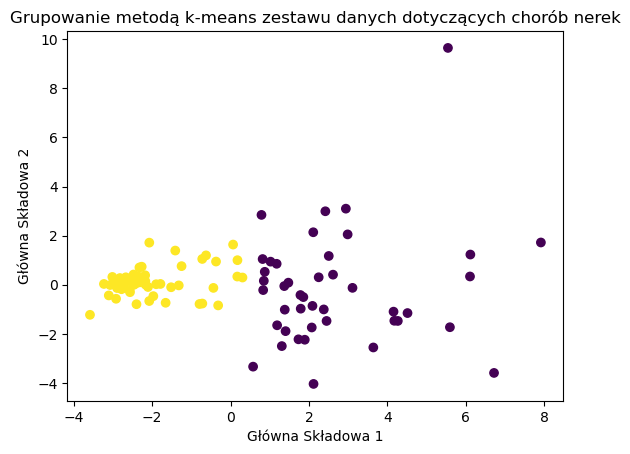

In [41]:
# Stosujemy klastrowanie K-Means
kmeans = KMeans(n_clusters = 2, random_state = nasz_seed_nienadzorowany)
kmeans.fit(X_train)

predicted_labels = kmeans.labels_

# Zmniejszamy wymiary danych przy użyciu PCA do celów wizualizacji
pca = PCA(n_components = 3, random_state = nasz_seed_nienadzorowany)
X_train_pca = pca.fit_transform(X_train)

# Rysujemy wykres
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c = predicted_labels, cmap = 'viridis')
plt.xlabel('Główna Składowa 1')
plt.ylabel('Główna Składowa 2')
plt.title('Grupowanie metodą k-means zestawu danych dotyczących chorób nerek')
plt.show()

W tym przykładzie uczenia modelu zastosowaliśmy algorytm grupowania K-średnich z $n\text{_clusters}=2$. Aby zwizualizować wynik należy zredukować wymiary za pomocą PCA do 2 głównych komponentów ze względu na charakter naszych danych. PCA nie jest konieczne do samego zastosowania algorytmu K-means, ale jest bardzo pomocne do wizualizacji wyników. Algorytm K-means działa w przestrzeni wielowymiarowej, ale wizualizacja danych w więcej niż trzech wymiarach jest trudna do zrozumienia i interpretacji. PCA (Analiza Składowych Głównych) pomaga zredukować wymiarowość danych, zachowując jak najwięcej informacji, co umożliwia nam tworzenie wykresów 2D lub 3D, które są łatwiejsze do zrozumienia.

PCA (Principal Component Analysis) jest techniką redukcji wymiarów, która służy do przekształcenia zbioru danych wielowymiarowych w zestaw mniejszej liczby wymiarów, nazywanych głównymi składowymi. Jest wykorzystywana w celu zmniejszenia złożoności danych poprzez identyfikację i zachowanie najważniejszych informacji zawartych w oryginalnym zbiorze danych.

### Grupowanie aglomeracyjne

Grupowanie aglomeracyjne tworzy hierarchię klastrów przez łączenie najbardziej podobnych punktów danych lub klastrów, podczas gdy K-means dzieli zbiór danych na k klastrów, minimalizując odległość między punktami a centroidami. Grupowanie aglomeracyjne nie wymaga wcześniejszego określenia liczby klastrów i może być bardziej skuteczne dla złożonych danych, podczas gdy K-means jest efektywny dla danych dobrze oddzielonych.

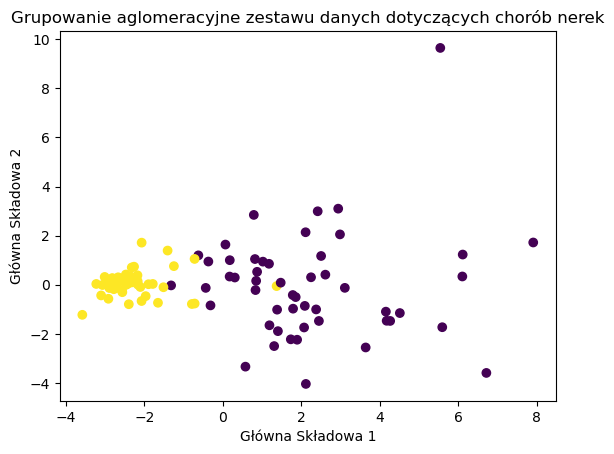

In [42]:
# Stosujemy grupowanie aglomeracyjne
kmeans = AgglomerativeClustering(n_clusters = 2)
kmeans.fit(X_train)

predicted_labels = kmeans.labels_

# Zmniejszamy wymiary danych przy użyciu PCA do celów wizualizacji
pca = PCA(n_components = 3, random_state = nasz_seed_nienadzorowany)
X_train_pca = pca.fit_transform(X_train)

# Rysujemy wykres
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c = predicted_labels, cmap = 'viridis')
plt.xlabel('Główna Składowa 1')
plt.ylabel('Główna Składowa 2')
plt.title('Grupowanie aglomeracyjne zestawu danych dotyczących chorób nerek')
plt.show()

W powyższym kodzie najpierw stosujemy algorytm grupowania aglomeracyjnego (Agglomerative Clustering) do przypisania punktów danych do odpowiednich klastrów. Następnie stosujemy PCA w celu zmniejszenia wymiarowości danych do trzech głównych składowych. Ostatecznie, wykreślamy punkty danych w przestrzeni dwuwymiarowej, używając dwóch głównych składowych uzyskanych przez PCA, a kolory punktów odpowiadają przewidywanym etykietom klastrów z algorytmu grupowania aglomeracyjnego.

## Wnioski

W projekcie przeanalizowano skuteczność różnych modeli klasyfikacyjnych, takich jak las losowy, SGBM, SVM, regresja logistyczna, drzewo decyzyjne, GBM i KNN, pod kątem ich dokładności i F1_score. Najlepsze wyniki osiągnęły modele las losowy, SGBM i SVM, które charakteryzują się wysoką skutecznością oraz równowagą między wskaźnikami dokładności i F1_score. Modele regresji logistycznej, drzewa decyzyjnego i GBM również uzyskały dobre wyniki, jednak były nieco niższe. Model KNN okazał się najmniej skuteczny spośród wszystkich analizowanych, co wskazuje na jego niższą wydajność w porównaniu do pozostałych metod. Natomiast modele uczenia nienadzorowanego, K-means oraz algorytm grupowania aglomeracyjnego (Agglomerative Clustering) w połączeniu z PCA okazały się skuteczne w identyfikacji naturalnych grup w danych, co umożliwiło lepsze zrozumienie wewnętrznych relacji i cech danych.